In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
from custom_preprocessor import preprocess
import json

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [2]:
df = pd.read_csv('./data/dataset_slavic.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language
9087,sa vrlo sa vrlo sa vrlo sa vrlo sa vrlo,Serbian
420,dva i polovina dva i polovina dva i polovina dva,Bulgarian
13458,juri je naglo juri je naglo juri je naglo juri,Slovenian
5949,detstvi z domu detstvi z domu detstvi z domu,Czech
1416,i tretata i tretata i tretata i tretata i,Bulgarian


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [3]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
print(f"Input dimension: {input_dim}")
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Input dimension: 48
Rows: 18738
Amount of languages to identify: 6


In [4]:
model = Sequential()
model.add(Conv1D(input_dim, 2, activation='relu'))  # Convolutional layer
tf.keras.layers.SimpleRNN(8, activation='relu')
model.add(LSTM(32, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [5]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=2048,verbose=1)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.1665 - loss: 2.1754 - val_accuracy: 0.1705 - val_loss: 1.7939
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.1703 - loss: 1.8069 - val_accuracy: 0.1708 - val_loss: 1.7869
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.1864 - loss: 1.7867 - val_accuracy: 0.2089 - val_loss: 1.7779
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.2219 - loss: 1.7753 - val_accuracy: 0.2372 - val_loss: 1.7589
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.2404 - loss: 1.7508 - val_accuracy: 0.2481 - val_loss: 1.7192
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.2574 - loss: 1.7223 - val_accuracy: 0.2809 - val_loss: 1.6963
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.2846 - loss: 1.7019 - val_accuracy: 0.3116 - val_loss: 1.6716
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.2972 - loss: 1.6786 - val_accuracy: 0.3202 - v

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

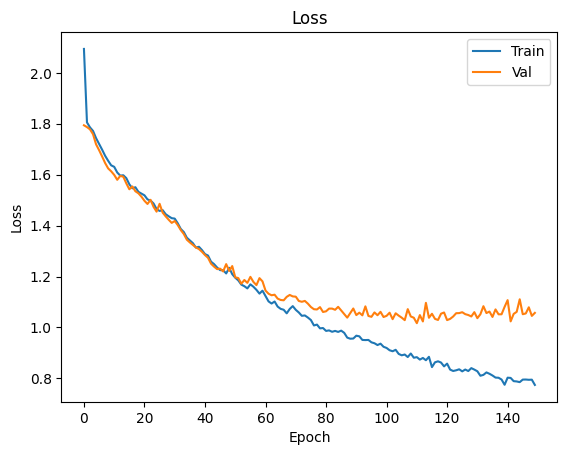

In [6]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

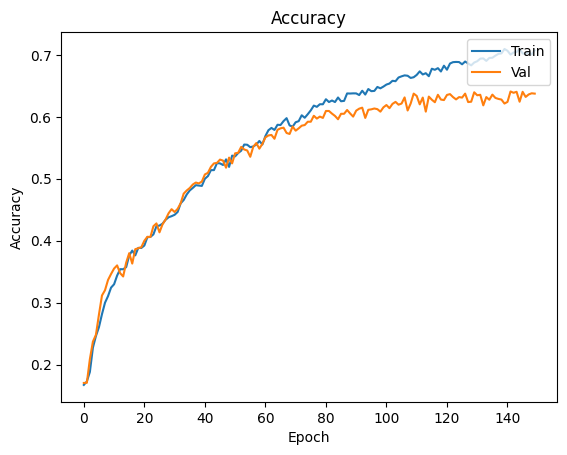

In [7]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Prediction

In [8]:
prediction_word = "времяпрепровождение"
print(f"Text before preprocessing: {prediction_word}")
prediction_word = preprocess(prediction_word)
print(f"Text after preprocessing: {prediction_word}")
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}")

Text before preprocessing: времяпрепровождение
Text after preprocessing: vremiapreprovozhdenie vremiapreprovozhdenie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Language_Bulgarian: 12.3
Language_Czech: 0.0
Language_Polish: 1.3
Language_Russian: 86.4
Language_Serbian: 0.0
Language_Slovenian: 0.0


# Save model
Here a model can be loaded

In [9]:
model.save('./models/model_slavic.keras')
tokenizer_json = tokenizer.to_json()
with open('./tokenizer_configs/tokenizer_config_slavic.json', 'w') as config_file:
    config_file.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Load model
Here a model can be loaded

In [10]:
model = load_model('./models/model_slavic.keras')